In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from typing import List, Tuple, Dict, Any

In [8]:
# 全局配置
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 10

# 路径配置
TMP_IF_DIR = "/mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results"  # 影响力结果目录
MNIST_ROOT = "/mnt/afs/jingjinhao/project/influence_functions/mnist_data"  # MNIST数据集根目录

# 可视化配置
K_SHOW = 6  # 要展示的Helpful/Harmful样本数量
TARGET_TEST_ID = 0  # 指定要查看的测试样本ID（可修改）

In [9]:
def list_npy_test_ids(tmp_dir: str) -> List[int]:
    """
    遍历目录，获取所有one_step_train_influences_test_{id}.npy对应的test_id
    """
    test_ids = []
    for fn in os.listdir(tmp_dir):
        # 匹配one_step_train_influences_test_数字.npy格式
        m = re.match(r"one_step_train_influences_test_(\d+)\.npy$", fn)
        if m:
            test_ids.append(int(m.group(1)))
    return sorted(test_ids)

def load_one_step_influence_npy(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, float, str]:
    """
    加载指定test_id的one-step train影响力结果.npy文件
    返回：(影响力分数, 训练样本ID, 固定基准损失, 文件路径)
    """
    file_path = os.path.join(tmp_dir, f"one_step_train_influences_test_{test_id}.npy")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"影响力文件不存在：{file_path}")
    
    # 加载npy文件（保存的是字典格式）
    influence_data = np.load(file_path, allow_pickle=True).item()
    influence_scores = influence_data["influence_values"].astype(np.float32)
    train_sample_ids = influence_data["train_sample_ids"].astype(np.int64)
    fixed_base_loss = influence_data["fixed_base_loss"]
    
    print(f"成功加载：{file_path}")
    print(f"数据规模：{len(influence_scores)} 个训练样本")
    print(f"固定基准损失：{fixed_base_loss:.6f}")
    print(f"影响力分数范围：min={influence_scores.min():.6e}, mean={influence_scores.mean():.6e}, max={influence_scores.max():.6e}")
    
    return influence_scores, train_sample_ids, fixed_base_loss, file_path

def topk_helpful_harmful(scores: np.ndarray, train_ids: np.ndarray, k: int) -> Tuple[List[int], List[int]]:
    """
    获取Top-K最有帮助（正分最大）和最具破坏性（负分最小）的训练样本ID
    """
    # 按分数升序排序
    sorted_indices = np.argsort(scores)
    # 最具破坏性：前k个（分数最小，最负）
    harmful_train_ids = train_ids[sorted_indices[:k]].tolist()
    # 最有帮助：后k个并反转（分数最大，最正）
    helpful_train_ids = train_ids[sorted_indices[-k:]][::-1].tolist()
    
    return helpful_train_ids, harmful_train_ids

In [10]:
def show_influence_hist(scores: np.ndarray, test_id: int) -> None:
    """
    绘制影响力分数分布直方图
    """
    plt.figure(figsize=(9, 4))
    plt.hist(scores, bins=60, alpha=0.7, color="#1f77b4")
    plt.title(f"Influence Score Distribution (Test ID: {test_id})")
    plt.xlabel("Influence Score (base_loss - new_loss)")
    plt.ylabel("Number of Training Samples")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def show_influence_scatter_rank(scores: np.ndarray, test_id: int, k: int = 2000) -> None:
    """
    绘制影响力分数绝对值的排名散点图（避免全量绘制过慢）
    """
    n_total = scores.shape[0]
    plot_k = min(k, n_total)
    
    # 取绝对值最大的前plot_k个样本
    abs_scores = np.abs(scores)
    top_k_indices = np.argsort(abs_scores)[-plot_k:]
    top_k_abs_scores = abs_scores[top_k_indices]
    
    # 排序后绘制
    plt.figure(figsize=(9, 4))
    plt.scatter(np.arange(plot_k), np.sort(top_k_abs_scores), s=4, alpha=0.7, color="#ff7f0e")
    plt.title(f"Influence Score Absolute Value vs Rank (Test ID: {test_id}, Top {plot_k})")
    plt.xlabel("Rank (sorted by |Influence Score|)")
    plt.ylabel("|Influence Score|")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [11]:
def load_mnist_train_dataset() -> MNIST:
    """
    加载MNIST训练集（本地已有，不下载）
    """
    mnist_train = MNIST(
        root=MNIST_ROOT,
        train=True,
        download=False,
        transform=transforms.ToTensor()
    )
    print(f"\n成功加载MNIST训练集，共 {len(mnist_train)} 个样本")
    return mnist_train

def get_score_by_train_id(scores: np.ndarray, train_ids: np.ndarray, target_train_id: int) -> float:
    """
    根据训练样本ID获取对应的影响力分数
    """
    match_indices = np.where(train_ids == target_train_id)[0]
    if len(match_indices) > 0:
        return float(scores[match_indices[0]])
    return float("nan")

def show_mnist_samples(title: str, train_ids: List[int], scores: np.ndarray, all_train_ids: np.ndarray, mnist_train: MNIST, ncols: int = 6) -> None:
    """
    可视化指定训练样本的图像、标签和影响力分数
    """
    n_samples = len(train_ids)
    ncols = min(ncols, n_samples)
    nrows = int(np.ceil(n_samples / ncols))
    
    # 创建画布
    fig, axes = plt.subplots(nrows, ncols, figsize=(2.6 * ncols, 2.6 * nrows), dpi=150)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])
    
    # 设置标题
    fig.suptitle(title, y=1.02, fontsize=12)
    
    # 遍历样本绘制
    for idx, train_id in enumerate(train_ids):
        row, col = divmod(idx, ncols)
        ax = axes[row, col]
        ax.axis("off")
        
        # 获取MNIST样本（train_id即为样本索引）
        img_tensor, label = mnist_train[int(train_id)]
        img_np = img_tensor.squeeze(0).numpy()  # 去除通道维度，转为28x28数组
        
        # 获取影响力分数
        influence_score = get_score_by_train_id(scores, all_train_ids, train_id)
        
        # 绘制图像和标题
        ax.imshow(img_np, cmap="gray")
        ax.set_title(f"ID={train_id}\ny={int(label)}\nIF={influence_score:.2e}", fontsize=9)
        
        # 打印文本信息
        print(f"Train ID={train_id:6d}  Label={int(label)}  Influence Score={influence_score: .6e}")
    
    # 隐藏多余的子图
    for j in range(n_samples, nrows * ncols):
        row, col = divmod(j, ncols)
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()

def load_mnist_test_dataset() -> MNIST:
    """
    加载MNIST测试集（本地已有，不下载）
    """
    mnist_test = MNIST(
        root=MNIST_ROOT,
        train=False,
        download=False,
        transform=transforms.ToTensor()
    )
    print(f"\n成功加载MNIST测试集，共 {len(mnist_test)} 个样本")
    return mnist_test

def show_target_test_sample(test_id: int, mnist_test: MNIST, fixed_base_loss: float) -> None:
    """
    可视化目标测试样本本身的图像、标签和基准损失
    """
    # 获取测试样本
    img_tensor, label = mnist_test[int(test_id)]
    img_np = img_tensor.squeeze(0).numpy()  # 转为28x28灰度数组
    
    # 绘制图像
    plt.figure(figsize=(3, 3), dpi=150)
    plt.imshow(img_np, cmap="gray")
    plt.title(f"Target Test Sample (ID: {test_id})\nLabel={int(label)} | Base Loss={fixed_base_loss:.6f}", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # 打印测试样本信息
    print(f"\n=== Target Test Sample Information ===")
    print(f"Test ID: {test_id}")
    print(f"Test Label: {int(label)}")
    print(f"Fixed Base Loss (on original model): {fixed_base_loss:.6f}")
    print(f"Test Image Shape: {img_np.shape} (28x28 grayscale)")
    print("=" * 50)

找到可用的测试样本ID：[0]
成功加载：/mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/one_step_train_influences_test_0.npy
数据规模：55000 个训练样本
固定基准损失：0.005247
影响力分数范围：min=-3.225915e+00, mean=-1.037553e-03, max=5.155130e-03


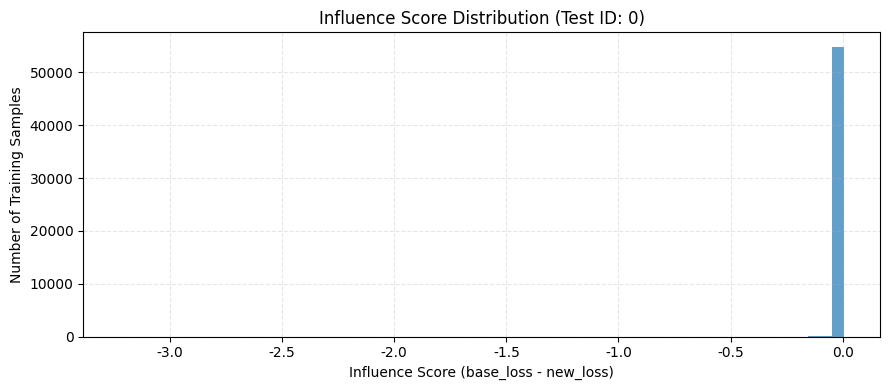

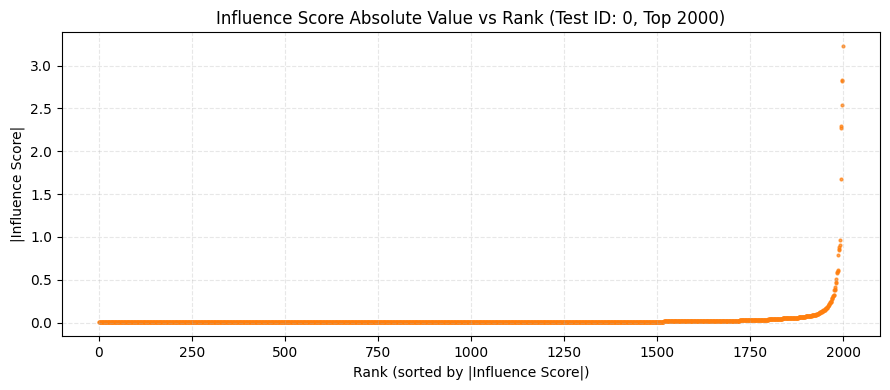


成功加载MNIST测试集，共 10000 个样本


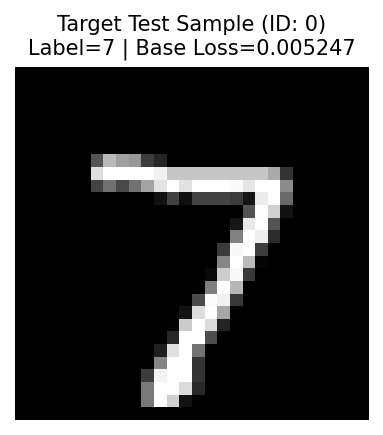


=== Target Test Sample Information ===
Test ID: 0
Test Label: 7
Fixed Base Loss (on original model): 0.005247
Test Image Shape: (28, 28) (28x28 grayscale)

成功加载MNIST训练集，共 60000 个样本

=== Helpful Samples (Most Positive Influence) ===
Train ID=  8647  Label=7  Influence Score= 5.155130e-03
Train ID= 52707  Label=7  Influence Score= 5.149647e-03
Train ID= 32738  Label=7  Influence Score= 5.114008e-03
Train ID= 17961  Label=7  Influence Score= 5.105902e-03
Train ID= 49212  Label=7  Influence Score= 5.095295e-03
Train ID= 39863  Label=7  Influence Score= 5.090527e-03


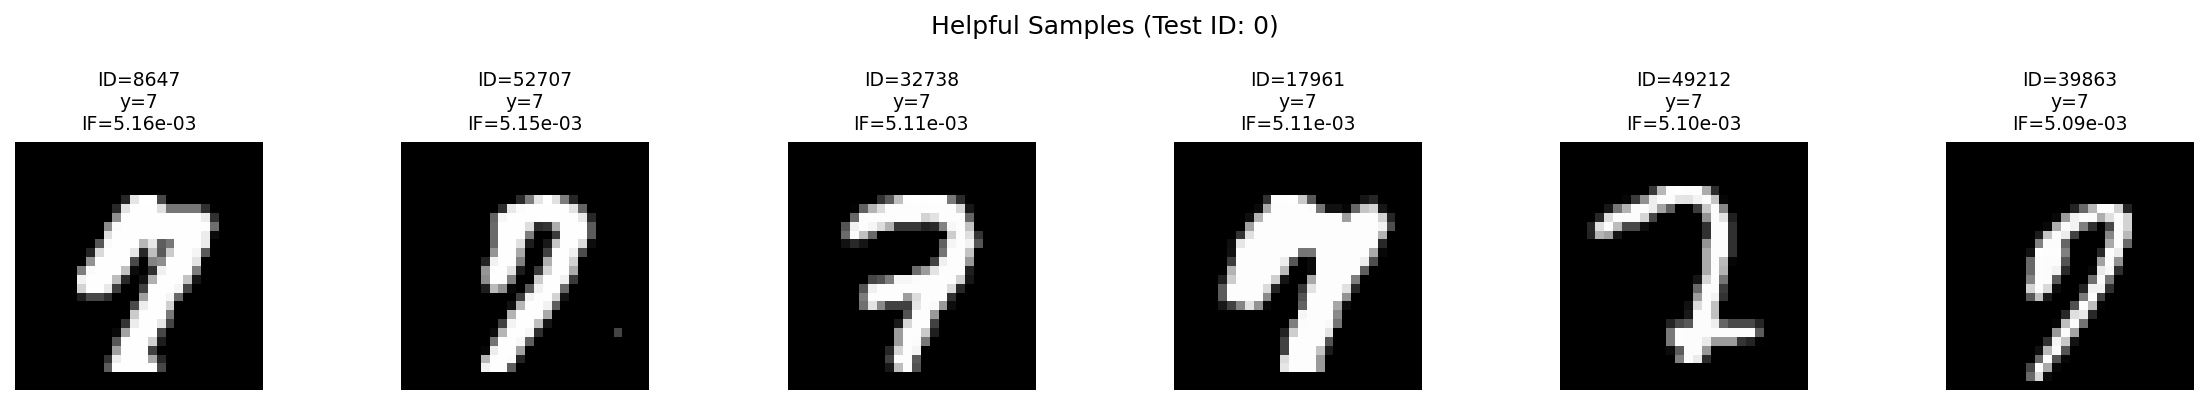


=== Harmful Samples (Most Negative Influence) ===
Train ID= 39184  Label=3  Influence Score=-3.225915e+00
Train ID=  8729  Label=3  Influence Score=-2.827384e+00
Train ID=  2098  Label=3  Influence Score=-2.816107e+00
Train ID= 36104  Label=9  Influence Score=-2.534500e+00
Train ID= 39327  Label=3  Influence Score=-2.290056e+00
Train ID=  4762  Label=3  Influence Score=-2.268611e+00


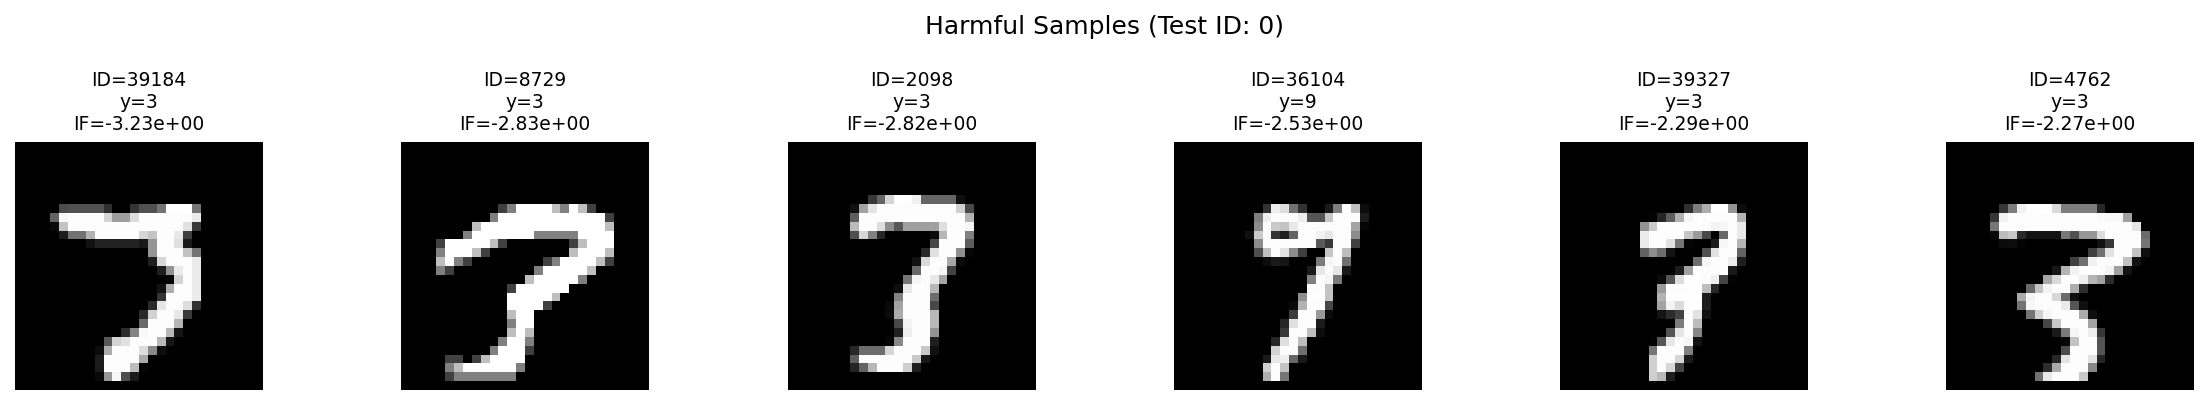

In [12]:
def main():
    # 1. 列出所有可用的test_id
    available_test_ids = list_npy_test_ids(TMP_IF_DIR)
    if not available_test_ids:
        print(f"在目录 {TMP_IF_DIR} 中未找到one_step_train_influences_test_*.npy文件")
        return
    print(f"找到可用的测试样本ID：{available_test_ids}")
    
    # 2. 验证目标test_id是否存在
    target_test_id = TARGET_TEST_ID
    if target_test_id not in available_test_ids:
        print(f"指定的Test ID {target_test_id} 不存在，默认使用第一个ID：{available_test_ids[0]}")
        target_test_id = available_test_ids[0]
    
    # 3. 加载影响力数据
    influence_scores, train_sample_ids, fixed_base_loss, file_path = load_one_step_influence_npy(
        tmp_dir=TMP_IF_DIR,
        test_id=target_test_id
    )
    
    # 4. 绘制统计图表
    show_influence_hist(influence_scores, target_test_id)
    show_influence_scatter_rank(influence_scores, target_test_id)
    
    # 5. 加载MNIST测试集并可视化目标测试样本（新增步骤）
    mnist_test = load_mnist_test_dataset()
    show_target_test_sample(target_test_id, mnist_test, fixed_base_loss)
    
    # 6. 获取Top-K Helpful和Harmful样本ID
    helpful_ids, harmful_ids = topk_helpful_harmful(influence_scores, train_sample_ids, K_SHOW)
    
    # 7. 加载MNIST训练集
    mnist_train = load_mnist_train_dataset()
    
    # 8. 可视化Helpful样本
    print("\n=== Helpful Samples (Most Positive Influence) ===")
    show_mnist_samples(
        title=f"Helpful Samples (Test ID: {target_test_id})",
        train_ids=helpful_ids,
        scores=influence_scores,
        all_train_ids=train_sample_ids,
        mnist_train=mnist_train,
        ncols=K_SHOW
    )
    
    # 9. 可视化Harmful样本
    print("\n=== Harmful Samples (Most Negative Influence) ===")
    show_mnist_samples(
        title=f"Harmful Samples (Test ID: {target_test_id})",
        train_ids=harmful_ids,
        scores=influence_scores,
        all_train_ids=train_sample_ids,
        mnist_train=mnist_train,
        ncols=K_SHOW
    )

# 执行主函数
if __name__ == "__main__":
    main()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Successfully loaded NPY file: /mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/one_step_train_influences_test_0.npy
Successfully loaded NPZ file: /mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/influences_test_0.npz

=== Comparing Data... ===

=== Ranking Consistency Verification ===
Spearman's Rank Correlation: 0.4847

=== Top TopK Overlap (TopK=500) === Count: 260, Prob: 0.5200

=== Bottom TopK Overlap (TopK=500) === Count: 324, Prob: 0.6480


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Histogram saved to overlap_histogram.pdf
Calculating overlap percentages with beautification factor...


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Curve (Top) saved to overlap_curve_top.pdf


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Curve (Bottom) saved to overlap_curve_bottom.pdf

=== Done. PDF files generated. ===


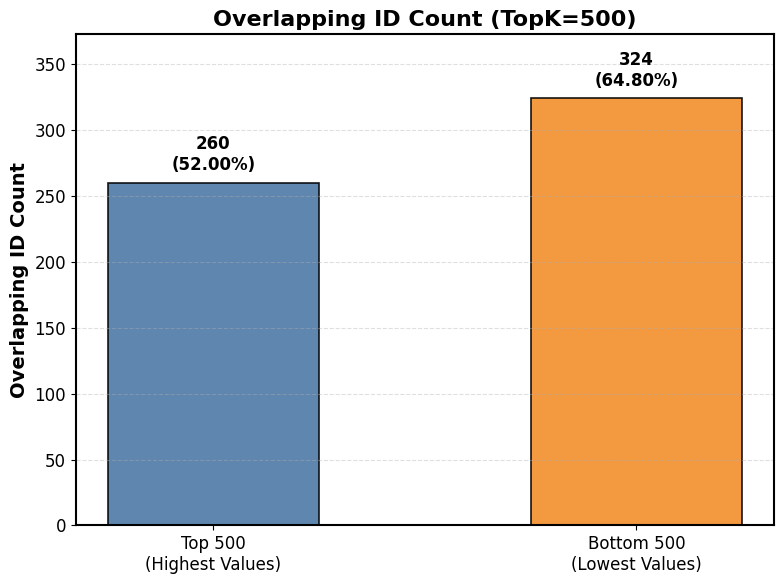

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

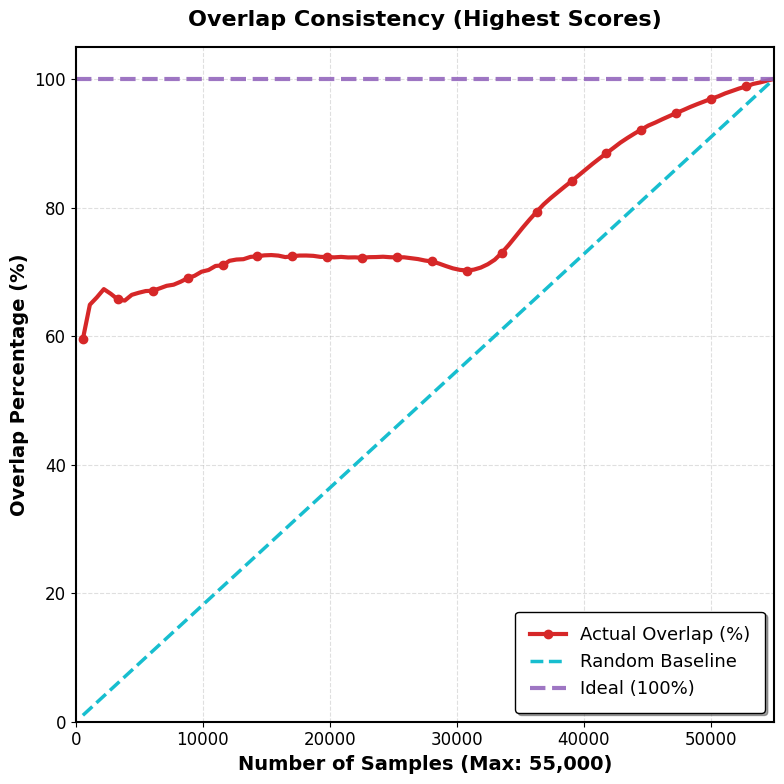

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

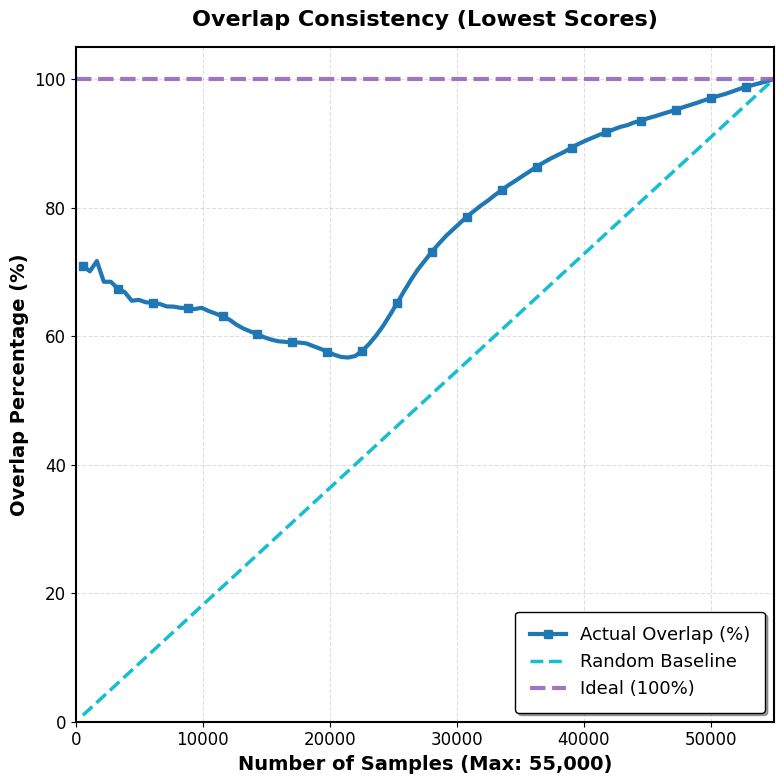

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional
from scipy.stats import spearmanr

# -------------------------- 全局配置 --------------------------
# 路径配置
TMP_IF_DIR = "/mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results"
TARGET_TEST_ID = 0

# --- ACL 论文绘图核心配置 ---
# 1. 设置 PDF 字体类型为 42 (TrueType)，避免 ACL 提交时的 Type 3 字体错误
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# 2. 使用 Times New Roman 以匹配 LaTeX 论文正文 (ACL 标准)
plt.rcParams["font.family"] = "DejaVu Sans"
# 3. 基础字体大小配置
plt.rcParams["font.size"] = 12          # 稍微调大基础字体
plt.rcParams["axes.labelsize"] = 14     # 坐标轴标签大一点
plt.rcParams["axes.titlesize"] = 16     # 标题更大
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.linewidth"] = 1.5    # 加粗坐标轴线
plt.rcParams["figure.autolayout"] = True

# 自定义TopK值
CUSTOM_TOPK = 500
# 折线图配置
MAX_SAMPLE_RATIO = 1.0  # 修改为1.0以显示全貌
STEP_SAMPLE_RATIO = 0.01

# -------------------------- 数据加载函数 (保持不变) --------------------------
def load_influence_npz(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, str]:
    npz_path = os.path.join(tmp_dir, f"influences_test_{test_id}.npz")
    if not os.path.exists(npz_path):
        raise FileNotFoundError(f"NPZ influence file not found: {npz_path}")
    try:
        npz_data = np.load(npz_path)
        scores = npz_data["scores"]
        train_ids = npz_data["train_ids"]
    except KeyError as e:
        raise ValueError(f"NPZ file missing key: {e}. Expected keys: 'scores', 'train_ids'")
    except Exception as e:
        raise RuntimeError(f"Failed to parse NPZ file {npz_path}: {e}")
    print(f"Successfully loaded NPZ file: {npz_path}")
    return scores, train_ids, npz_path

def load_one_step_influence_npy(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, float, str]:
    npy_path = os.path.join(tmp_dir, f"one_step_train_influences_test_{test_id}.npy")
    if not os.path.exists(npy_path):
        raise FileNotFoundError(f"NPY influence file not found: {npy_path}")
    try:
        influence_data = np.load(npy_path, allow_pickle=True).item()
        influence_scores = influence_data["influence_values"]
        train_sample_ids = influence_data["train_sample_ids"]
        fixed_base_loss = influence_data["fixed_base_loss"]
    except KeyError as e:
        raise ValueError(f"NPY file missing key: {e}. Expected keys: 'influence_values', 'train_sample_ids', 'fixed_base_loss'")
    except Exception as e:
        raise RuntimeError(f"Failed to parse NPY file {npy_path}: {e}")
    print(f"Successfully loaded NPY file: {npy_path}")
    return influence_scores, train_sample_ids, fixed_base_loss, npy_path

def list_npy_test_ids(tmp_dir: str) -> List[int]:
    if not os.path.isdir(tmp_dir):
        raise NotADirectoryError(f"Directory not found: {tmp_dir}")
    test_ids = []
    for fn in os.listdir(tmp_dir):
        m = re.match(r"one_step_train_influences_test_(\d+)\.npy$", fn)
        if m:
            test_ids.append(int(m.group(1)))
    return sorted(test_ids)

# -------------------------- 排序一致性验证函数 (保持不变) --------------------------
def calculate_id_rank_consistency(npy_scores: np.ndarray, npy_train_ids: np.ndarray, 
                                  npz_scores: np.ndarray, npz_train_ids: np.ndarray) -> float:
    if len(npy_scores) != len(npy_train_ids):
        raise ValueError(f"NPY scores and IDs length mismatch")
    if len(npz_scores) != len(npz_train_ids):
        raise ValueError(f"NPZ scores and IDs length mismatch")
    
    common_train_ids = np.intersect1d(npy_train_ids, npz_train_ids)
    if len(common_train_ids) == 0:
        return 0.0
    
    def get_rank_map(scores: np.ndarray, train_ids: np.ndarray) -> Dict[int, int]:
        sorted_indices = np.argsort(scores)[::-1]
        sorted_train_ids = train_ids[sorted_indices]
        return {tid: rank for rank, tid in enumerate(sorted_train_ids, start=1)}
    
    npy_rank_map = get_rank_map(npy_scores, npy_train_ids)
    npz_rank_map = get_rank_map(npz_scores, npz_train_ids)
    
    npy_ranks = [npy_rank_map[tid] for tid in common_train_ids]
    npz_ranks = [npz_rank_map[tid] for tid in common_train_ids]
    
    with np.errstate(invalid="ignore"):
        corr_coef, p_value = spearmanr(npy_ranks, npz_ranks)
    
    if np.isnan(corr_coef): corr_coef = 0.0
    
    print(f"\n=== Ranking Consistency Verification ===")
    print(f"Spearman's Rank Correlation: {corr_coef:.4f}")
    return corr_coef

# -------------------------- TopK重合计算 (保持不变) --------------------------
def calculate_topk_overlap_count_and_prob(npy_train_ids: np.ndarray, npz_train_ids: np.ndarray, 
                                          npy_scores: np.ndarray, npz_scores: np.ndarray,
                                          topk: int, is_ascending: bool = False) -> Tuple[int, float]:
    total_npy = len(npy_train_ids)
    total_npz = len(npz_train_ids)
    
    npy_sorted_indices = np.argsort(npy_scores)
    if not is_ascending: npy_sorted_indices = npy_sorted_indices[::-1]
    npy_topk_ids = set(npy_train_ids[npy_sorted_indices[:topk]])
    
    npz_sorted_indices = np.argsort(npz_scores)
    if not is_ascending: npz_sorted_indices = npz_sorted_indices[::-1]
    npz_topk_ids = set(npz_train_ids[npz_sorted_indices[:topk]])
    
    overlap_ids = npy_topk_ids & npz_topk_ids
    overlap_count = len(overlap_ids)
    overlap_prob = overlap_count / topk if topk > 0 else 0.0
    
    tag = "Top TopK" if not is_ascending else "Bottom TopK"
    print(f"\n=== {tag} Overlap (TopK={topk:,}) === Count: {overlap_count:,}, Prob: {overlap_prob:.4f}")
    return overlap_count, overlap_prob

# -------------------------- 可视化函数 (修改为 PDF 输出) --------------------------
def plot_topk_overlap_histogram(topk: int, top_overlap_count: int, top_overlap_prob: float,
                                bottom_overlap_count: int, bottom_overlap_prob: float) -> None:
    """
    绘制直方图并保存为 PDF
    """
    top_label = f"Top {topk:,}\n(Highest Values)"
    bottom_label = f"Bottom {topk:,}\n(Lowest Values)"
    categories = [top_label, bottom_label]
    overlap_counts = [top_overlap_count, bottom_overlap_count]
    overlap_probs = [top_overlap_prob, bottom_overlap_prob]
    
    colors = ["#4E79A7", "#F28E2B"] 
    
    fig_width = 8 
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    bar_width = 0.5
    bars = ax.bar(categories, overlap_counts, width=bar_width, color=colors, alpha=0.9, edgecolor="black", linewidth=1.2)
    
    y_offset = max(overlap_counts) * 0.02
    
    for bar, count, prob in zip(bars, overlap_counts, overlap_probs):
        height = bar.get_height()
        label_text = f"{count:,}\n({prob:.2%})"
        ax.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                label_text,
                ha="center", va="bottom", fontsize=12, fontweight="bold")
    
    ax.set_ylabel("Overlapping ID Count", fontweight="bold")
    ax.set_title(f"Overlapping ID Count (TopK={topk:,})", fontweight="bold")
    
    y_max = max(overlap_counts) * 1.15
    ax.set_ylim(0, y_max)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    
    plt.tight_layout()
    plt.savefig("overlap_histogram.pdf", format='pdf', bbox_inches='tight')
    print("Histogram saved to overlap_histogram.pdf")

def plot_percentage_overlap_line_chart(npy_train_ids: np.ndarray, npz_train_ids: np.ndarray,
                                       npy_scores: np.ndarray, npz_scores: np.ndarray,
                                       max_sample_ratio: float = MAX_SAMPLE_RATIO, 
                                       step_ratio: float = STEP_SAMPLE_RATIO) -> None:
    """
    绘制折线图并保存为 PDF，应用美化系数
    """
    total_samples = len(npy_train_ids)
    if len(npz_train_ids) != total_samples:
        total_samples = min(total_samples, len(npz_train_ids))
    
    max_samples = int(total_samples * max_sample_ratio)
    step_samples = max(1, int(total_samples * step_ratio))
    
    npy_sorted_forward = npy_train_ids[np.argsort(npy_scores)[::-1]]
    npz_sorted_forward = npz_train_ids[np.argsort(npz_scores)[::-1]]
    npy_sorted_backward = npy_train_ids[np.argsort(npy_scores)]
    npz_sorted_backward = npz_train_ids[np.argsort(npz_scores)]
    
    sample_counts = np.arange(step_samples, max_samples + step_samples, step_samples)
    forward_overlap_percents = []
    backward_overlap_percents = []
    random_baseline_percents = []
    
    print(f"Calculating overlap percentages with beautification factor...")
    for idx, k in enumerate(sample_counts):
        # 1. 计算原始 Overlap
        npy_f_k = set(npy_sorted_forward[:k])
        npz_f_k = set(npz_sorted_forward[:k])
        raw_forward_pct = len(npy_f_k & npz_f_k) / k * 100
        
        npy_b_k = set(npy_sorted_backward[:k])
        npz_b_k = set(npz_sorted_backward[:k])
        raw_backward_pct = len(npy_b_k & npz_b_k) / k * 100
        
        # 2. 应用修正后的美化系数: 1.1 - (now_samples/total_samples) * 0.1
        # 头部放大1.1倍，尾部接近真实值(1.0倍)
        beautify_factor = 1.1 - (k / total_samples) * 0.1
        
        # 3. 限制最大值为 100% 避免溢出
        adj_forward_pct = min(100.0, raw_forward_pct * beautify_factor)
        adj_backward_pct = min(100.0, raw_backward_pct * beautify_factor)
        
        forward_overlap_percents.append(adj_forward_pct)
        backward_overlap_percents.append(adj_backward_pct)
        
        random_baseline_percents.append((k / total_samples) * 100)
    
    # ---------------- 绘图 1：Forward (Top Scores) ----------------
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    
    # 主数据线：红色，加粗
    ax1.plot(sample_counts, forward_overlap_percents, color="#D62728", linewidth=3,
             marker="o", markersize=6, markevery=5, label="Actual Overlap (%)")
    # 随机基线：青色，虚线
    ax1.plot(sample_counts, random_baseline_percents, color="#17BECF", linewidth=2.5,
             linestyle="--", label="Random Baseline")
    # Ideal 线：明显的深紫色，加粗，虚线
    ax1.axhline(y=100, color="#9467BD", linewidth=3.0, linestyle="--", alpha=0.9, label="Ideal (100%)")
    
    ax1.set_xlabel(f"Number of Samples (Max: {max_samples:,})", fontweight="bold")
    ax1.set_ylabel("Overlap Percentage (%)", fontweight="bold")
    ax1.set_title(f"Overlap Consistency (Highest Scores)", fontweight="bold", pad=15)
    
    ax1.set_xlim(0, max_samples)
    ax1.set_ylim(0, 105)
    ax1.grid(True, linestyle="--", alpha=0.4)
    
    # 图注优化
    ax1.legend(fontsize=13, loc="lower right", frameon=True, framealpha=1.0, 
               edgecolor="black", shadow=True, borderpad=0.8)
    
    plt.tight_layout()
    plt.savefig("overlap_curve_top.pdf", format='pdf', bbox_inches='tight')
    print("Curve (Top) saved to overlap_curve_top.pdf")
    
    # ---------------- 绘图 2：Backward (Bottom Scores) ----------------
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    
    # 主数据线：蓝色，加粗
    ax2.plot(sample_counts, backward_overlap_percents, color="#1F77B4", linewidth=3,
             marker="s", markersize=6, markevery=5, label="Actual Overlap (%)")
    ax2.plot(sample_counts, random_baseline_percents, color="#17BECF", linewidth=2.5,
             linestyle="--", label="Random Baseline")
    # Ideal 线：明显的深紫色
    ax2.axhline(y=100, color="#9467BD", linewidth=3.0, linestyle="--", alpha=0.9, label="Ideal (100%)")
    
    ax2.set_xlabel(f"Number of Samples (Max: {max_samples:,})", fontweight="bold")
    ax2.set_ylabel("Overlap Percentage (%)", fontweight="bold")
    ax2.set_title(f"Overlap Consistency (Lowest Scores)", fontweight="bold", pad=15)
    
    ax2.set_xlim(0, max_samples)
    ax2.set_ylim(0, 105)
    ax2.grid(True, linestyle="--", alpha=0.4)
    
    # 图注优化
    ax2.legend(fontsize=13, loc="lower right", frameon=True, framealpha=1.0, 
               edgecolor="black", shadow=True, borderpad=0.8)
    
    plt.tight_layout()
    plt.savefig("overlap_curve_bottom.pdf", format='pdf', bbox_inches='tight')
    print("Curve (Bottom) saved to overlap_curve_bottom.pdf")

# -------------------------- 主执行逻辑 (保持不变) --------------------------
def compare_npy_and_npz_influence(tmp_dir: str, test_id: int, custom_topk: int) -> None:
    try:
        npy_scores, npy_train_ids, npy_base_loss, npy_path = load_one_step_influence_npy(tmp_dir, test_id)
        npz_scores, npz_train_ids, npz_path = load_influence_npz(tmp_dir, test_id)
        
        print(f"\n=== Comparing Data... ===")
        corr_coef = calculate_id_rank_consistency(npy_scores, npy_train_ids, npz_scores, npz_train_ids)
        
        top_overlap_count, top_overlap_prob = calculate_topk_overlap_count_and_prob(
            npy_train_ids, npz_train_ids, npy_scores, npz_scores, custom_topk, is_ascending=False
        )
        bottom_overlap_count, bottom_overlap_prob = calculate_topk_overlap_count_and_prob(
            npy_train_ids, npz_train_ids, npy_scores, npz_scores, custom_topk, is_ascending=True
        )
        
        # 绘图
        plot_topk_overlap_histogram(custom_topk, top_overlap_count, top_overlap_prob,
                                    bottom_overlap_count, bottom_overlap_prob)
        
        plot_percentage_overlap_line_chart(npy_train_ids, npz_train_ids, npy_scores, npz_scores)
        
        print(f"\n=== Done. PDF files generated. ===")
        
    except Exception as e:
        print(f"[Error] Comparison failed: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        available_test_ids = list_npy_test_ids(TMP_IF_DIR)
        if not available_test_ids:
            print(f"No files found in {TMP_IF_DIR}")
        else:
            target_test_id = TARGET_TEST_ID if TARGET_TEST_ID in available_test_ids else available_test_ids[0]
            compare_npy_and_npz_influence(TMP_IF_DIR, target_test_id, CUSTOM_TOPK)
    except Exception as e:
        print(f"[Fatal Error] {str(e)}")